# Aplicación de arquitectura LSTM para muestra 100s
El problema ahora se encarará empleando redes neuronales de tipo _Long Short-Term Memory_ (LSTM). 

## Librerías necesarias

In [1]:
# Librerías principales
import os
import numpy as np
import pandas as pd

# Herramientas para graficar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import signal

from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.models import Model
from keras.layers import Input


# Versiones de librerías
print("".join(f"{x[0]}: {x[1]}\n" for x in [
    ("Numpy",np.__version__),
    ("Pandas",pd.__version__),
]))


Numpy: 1.21.6
Pandas: 1.3.5



## Sliding Window
Se hace un modelo de juguete para visualizar cómo funciona el algoritmo

In [2]:
a = [x for x in range(0, 30, 1)]

Se empieza por mostrar cómo se comporta una configuración tipo _sliding window_

In [3]:
# largo de la secuencia, incluye input + output
train_len = 4

seq_w = []
for i in range(train_len, len(a)):
  seq = a[i-train_len:i]
  seq_w.append(seq)

In [4]:
seq_w[:3]

[[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5]]

In [5]:
seq_w = np.array(seq_w)
input_w = seq_w[:,:-1] # todos los rows, menos la ultima col
target_w = seq_w[:, -1] # última col de cada row

print("Input_w (primeras 3 filas):", input_w[:3])
print("Target_w (primeros 3 valores):", target_w[:3])

Input_w (primeras 3 filas): [[0 1 2]
 [1 2 3]
 [2 3 4]]
Target_w (primeros 3 valores): [3 4 5]


## Carga del dataset
Se carga un dataset a la vez, como primer prueba

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/Colab Notebooks/tsa/data'
files_name = 'dataset_100s.csv'

In [8]:
df = pd.read_csv(os.path.join(path, files_name), index_col='Time')
df.describe()

,Bearing 1
count,3000.000000
mean,-0.003400
std,0.124253
min,-0.564000
25%,-0.078000
50%,-0.005000
75%,0.071000
max,0.566000


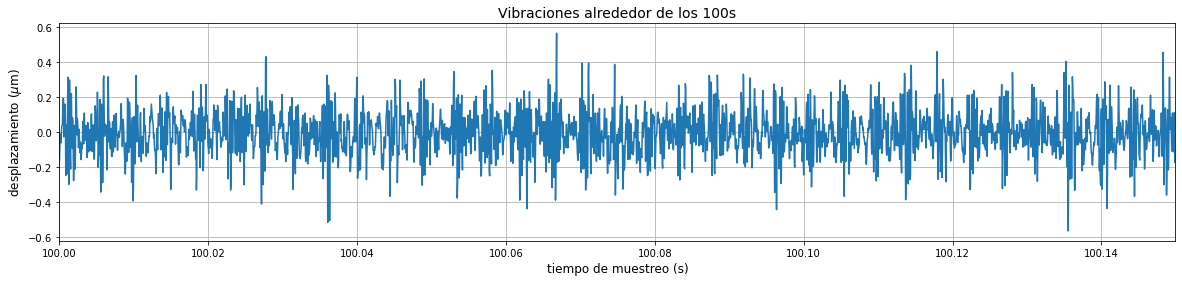

In [9]:
plt.figure(figsize=(20,4))

plt.plot(df.index, df)
plt.xlim(df.index[0], df.index[-1])
plt.grid()
plt.xlabel('tiempo de muestreo (s)', fontsize=12)
plt.ylabel('desplazamiento ($\mu$m)', fontsize=12)
plt.title(f'Vibraciones alrededor de los 100s', fontsize=14)

plt.show()

## Preprocesamiento


In [10]:
tokens = df['Bearing 1'].tolist()
tokens[:10]

[-0.161, -0.073, -0.01, -0.037, -0.061, -0.027, 0.032, 0.037, 0.046, 0.139]

In [11]:
time = df.index.tolist()
time[:10]

[100.0,
 100.00005,
 100.0001,
 100.00015,
 100.0002,
 100.00025,
 100.0003,
 100.00035,
 100.0004,
 100.00045]

In [12]:
# Código para hacer el desfazaje de los tokens
# según el train_len
train_len = 20

sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  sequences.append(seq)

In [13]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# sequences[:5]

In [14]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 2980


## Input y Target

In [15]:
arr_sequences = np.array(sequences)
X = arr_sequences[:,:-1]
y = arr_sequences[:,-1]

print("Dimensiones input:", X.shape)
print("Dimensiones target:", y.shape)

Dimensiones input: (2980, 19)
Dimensiones target: (2980,)


## Preparación 


In [16]:
# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
# Cada dato lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X_train = np.array(X_train).reshape(len(X_train), len(X_train[0]), 1)
X_test = np.array(X_test).reshape(len(X_test), len(X_test[0]), 1)
print("Dimensiones X_train:", X_train.shape)
print("Dimensiones X_test:", X_test.shape)

Dimensiones X_train: (2384, 19, 1)
Dimensiones X_test: (596, 19, 1)


## Modelo

In [18]:
input_shape = X_train[0].shape
input_shape

(19, 1)

In [19]:
output_shape = 1
output_shape

1

In [20]:
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh'))
model.add(Dense(output_shape))
model.compile(loss='mse',
              optimizer="Adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 19, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 19, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=5)

Epoch 1/50
382/382 [==============================] - 13s 11ms/step - loss: 0.0148 - val_loss: 0.0168
Epoch 2/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 3/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0145 - val_loss: 0.0160
Epoch 4/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0145 - val_loss: 0.0162
Epoch 5/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0133 - val_loss: 0.0087
Epoch 6/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 7/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 8/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 9/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 10/50
382/382 [==============================] - 3s 8ms/step - loss: 0.0073 - val_loss: 0.00

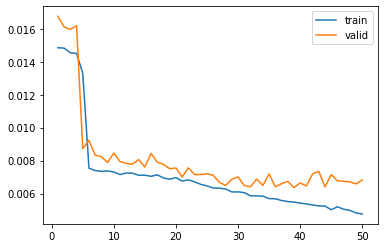

In [22]:
# Preformance de Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

## Resultados

In [23]:
y_hat_train = model.predict(X_train, verbose=0)
y_hat_test = model.predict(X_test, verbose=0)

In [24]:
print("y_hat_train:", y_hat_train.shape)
print("y_hat_test:", y_hat_test.shape)

y_hat_train: (2384, 1)
y_hat_test: (596, 1)


In [25]:
arr_tokens = np.array(tokens).reshape(-1,1)
arr_time = np.array(time).reshape(-1,1)

print(arr_tokens.shape)
print(arr_time.shape)

(3000, 1)
(3000, 1)


In [26]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(arr_tokens)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[train_len-1:len(y_hat_train)+train_len-1,:] = y_hat_train

# # predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(arr_tokens)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_hat_train)+(train_len)-2:len(arr_tokens)-2, :] = y_hat_test

print(trainPredictPlot.shape)
print(testPredictPlot.shape)

(3000, 1)
(3000, 1)


In [27]:
y_hat_train[0]

array([-0.08180811], dtype=float32)

In [28]:
len(y_hat_train)+(train_len)

2404

In [29]:
import plotly.graph_objs as go

import plotly.io as pio
pio.renderers.default = "colab"


def plot_predictions(y, time, y_pred_train, y_pred_test):
    data = []
    
    value = go.Scatter(
        x=time,
        y=y,
        mode="lines",
        name="Ensayo",
        marker=dict(),
        text=time,
        line=dict(color="rgba(0, 0, 250, 0.6)"),
    )
    data.append(value)

    trainPredic = go.Scatter(
        x=time,
        y=y_pred_train,
        mode="lines",
        line=dict(color="orange"),
        name='Predicción set train',
        marker=dict(),
        text=time,
        opacity=0.8,
    )
    data.append(trainPredic)
    
    testPredictions = go.Scatter(
        x=time,
        y=y_pred_test,
        mode="lines",
        line=dict(color="rgba(0, 250, 0, 0.6)"),
        name='Predicción set test',
        marker=dict(),
        text=time,
        opacity=0.8,
    )
    data.append(testPredictions)
    
    layout = dict(
        title='Comparativa de resultados para 100s',
        xaxis=dict(title="tiempo de muestreo (s)", ticklen=5, zeroline=False),
        yaxis=dict(title="desplazamiento ($\mu$m)", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    pio.show(fig)
    
    
# Set notebook mode to work in offline
# pyo.init_notebook_mode()
plot_predictions(tokens, time, trainPredictPlot[:,0], testPredictPlot[:,0])


## Comparativa espectral

In [30]:
y.shape

(2980,)

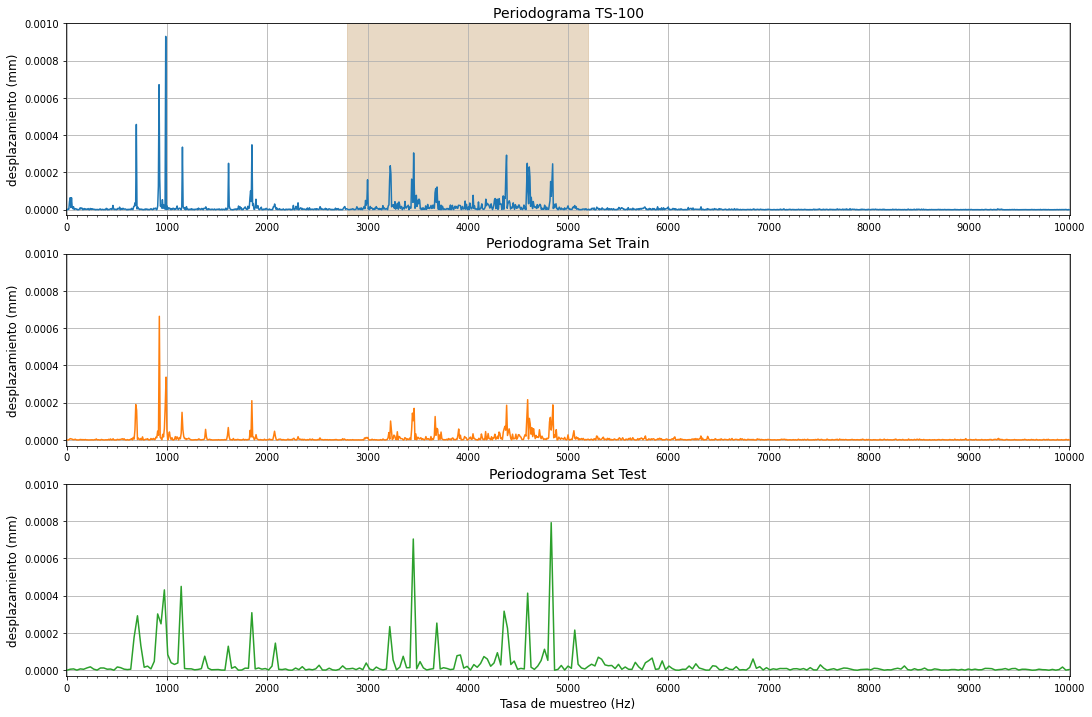

In [31]:
fig = plt.figure(figsize=(18, 12))

#------------------
fr_100, A_100 = signal.periodogram(tokens,len(tokens))
arr_sr = np.linspace(0, 10000, len(fr_100), dtype='float32')
ax1 = plt.subplot(311)
ax1.plot(arr_sr, A_100, 'C0')
ax1.set_xlim(arr_sr[0]-10, arr_sr[-1]+10)
ax1.set_ylim(-0.00003, 0.001)
ax1.grid()
ax1.fill_betweenx([-0.00003, 0.001],arr_sr[420], arr_sr[780], color ='tan', alpha = 0.5)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1000))
# ax1.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax1.set_ylabel('desplazamiento (mm)', fontsize=12)
ax1.set_title(f'Periodograma TS-100', fontsize=14)

#------------------
fr_hat_train, A_hat_train = signal.periodogram(y_hat_train[:,0],len(y_hat_train))
arr_sr_hat_train = np.linspace(0, 10000, len(fr_hat_train), dtype='float32')
ax2 = plt.subplot(312)
ax2.plot(arr_sr_hat_train, A_hat_train, 'C1')
ax2.set_xlim(arr_sr_hat_train[0]-10, arr_sr_hat_train[-1]+10)
ax2.set_ylim(-0.00003, 0.001)
ax2.grid()
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1000))
# ax2.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax2.set_ylabel('desplazamiento (mm)', fontsize=12)
ax2.set_title(f'Periodograma Set Train', fontsize=14)

#-------------------
fr_hat_test, A_hat_test = signal.periodogram(y_hat_test[:,0],len(y_hat_test))
arr_sr_hat_test = np.linspace(0, 10000, len(fr_hat_test), dtype='float32')
ax3 = plt.subplot(313)
ax3.plot(arr_sr_hat_test, A_hat_test, 'C2')
ax3.set_xlim(arr_sr_hat_test[0]-10, arr_sr_hat_test[-1]+10)
ax3.set_ylim(-0.00003, 0.001)
ax3.grid()
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax3.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax3.set_ylabel('desplazamiento (mm)', fontsize=12)
ax3.set_title(f'Periodograma Set Test', fontsize=14)

plt.show()